# Построение модели определения стоимости автомобиля

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Цель исследования - построить модель, которая умеет определять рыночную стоимость автомобиля.

В нашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

Описание данных

Признаки

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

Критерии, которые необходимо учесть:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

В рамках исследования необходимо:
- Подготовить данные;
- Подготовить выборки для обучения моделей;
- Построить и обучить несколько моделей;
- Проанализировать время обучения, время предсказания и качество моделей;
- Проверить качество лучшей модели на тестовой выборке.

## Подготовка данных

In [1]:
!pip install scikit-learn==1.1.3

     |████████████████████████████████| 30.8 MB 45 kB/s s eta 0:00:01   |▊                               | 706 kB 964 kB/s eta 0:00:32     |████████                        | 7.7 MB 2.8 MB/s eta 0:00:09     |████████████                    | 11.6 MB 2.8 MB/s eta 0:00:07
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.shape

(354369, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.duplicated().sum()

4

In [7]:
data = data.drop_duplicates()

In [8]:
data.duplicated().sum()

0

In [9]:
data.isna().sum()/len(data)*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579487
RegistrationYear      0.000000
Gearbox               5.596772
Power                 0.000000
Model                 5.560651
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282802
Brand                 0.000000
Repaired             20.079297
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Итак, около 5% пропусков в столбцах Модель автомобиля и тип коробки передач, удалим эти строки, так как запоолнить их не представлется возможным.

In [10]:
data = data.dropna(subset=['Gearbox', 'Model'])

In [11]:
data.isna().sum()/len(data)*100

DateCrawled           0.000000
Price                 0.000000
VehicleType           7.431699
RegistrationYear      0.000000
Gearbox               0.000000
Power                 0.000000
Model                 0.000000
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              6.187021
Brand                 0.000000
Repaired             16.529763
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Итак, остается довольно большой процент пропусков в столбцах с информацией о типе кузова, была ли машина в ремонте и тип топлива. 
Поскольку восстановить эти данные не представляется возможным, заменим пропуски на значение unknown.

In [12]:
data['VehicleType'].fillna('unknown', inplace=True)
data['Repaired'].fillna('unknown', inplace=True)
data['FuelType'].fillna('unknown', inplace=True)

In [13]:
data.isna().sum()/len(data)*100

DateCrawled          0.0
Price                0.0
VehicleType          0.0
RegistrationYear     0.0
Gearbox              0.0
Power                0.0
Model                0.0
Kilometer            0.0
RegistrationMonth    0.0
FuelType             0.0
Brand                0.0
Repaired             0.0
DateCreated          0.0
NumberOfPictures     0.0
PostalCode           0.0
LastSeen             0.0
dtype: float64

In [14]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,318958.000000,318958.000000,318958.000000,318958.000000,318958.000000,318958.0,318958.000000
mean,4608.905502,2003.427031,114.965265,128844.738179,5.908107,0.0,50766.394149
std,4564.241216,30.517461,185.627579,36620.680186,3.634281,0.0,25780.246706
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1200.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30455.000000
50%,2900.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49610.000000
75%,6700.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71357.000000
max,20000.000000,9000.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Теперь удалим столбцы, которые не нужны нам для целей машиного обучения:

- PostalCode
- NumberOfPictures(везде нулевые значения)
- DateCrawled
- DateCreated
- LastSeen

In [15]:
data.groupby('DateCrawled').count().sort_values(by='DateCrawled')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
DateCrawled,,,,,,,,,,,,,,,
2016-03-05 14:06:22,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2016-03-05 14:06:23,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2016-03-05 14:06:24,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2016-03-05 14:06:25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2016-03-05 14:06:26,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-07 14:36:53,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2016-04-07 14:36:54,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2016-04-07 14:36:55,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [16]:
data = data.drop(['PostalCode', 'NumberOfPictures', 'DateCrawled','DateCreated','LastSeen'], axis=1)

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318958 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              318958 non-null  int64 
 1   VehicleType        318958 non-null  object
 2   RegistrationYear   318958 non-null  int64 
 3   Gearbox            318958 non-null  object
 4   Power              318958 non-null  int64 
 5   Model              318958 non-null  object
 6   Kilometer          318958 non-null  int64 
 7   RegistrationMonth  318958 non-null  int64 
 8   FuelType           318958 non-null  object
 9   Brand              318958 non-null  object
 10  Repaired           318958 non-null  object
dtypes: int64(5), object(6)
memory usage: 29.2+ MB


Далее разберемся со столбцами, в которых есть выбросы, выше мы заметили, что в столбе Цена есть нулевые значения, в столбце Год присутствуют значения 1000 и 9000,в столбце Мощность также есть аномальные значения, в графе Месяц регистристрации присутствуют нули. Рассмотрим по порядку.

<AxesSubplot:xlabel='Price', ylabel='Count'>

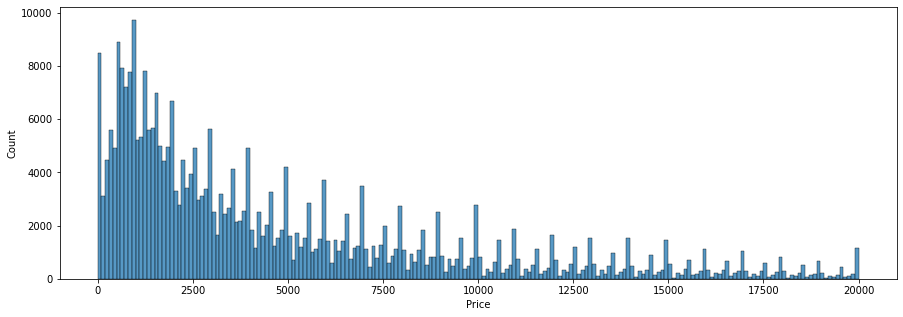

In [18]:
# рассмотрим расспределение по цене
plt.figure(figsize=(15,5))  
sns.histplot(data['Price'],bins=200)

In [19]:
data.groupby('Price').count().sort_values(by='Price')

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Price,,,,,,,,,,
0,7156,7156,7156,7156,7156,7156,7156,7156,7156,7156
1,715,715,715,715,715,715,715,715,715,715
2,9,9,9,9,9,9,9,9,9,9
3,5,5,5,5,5,5,5,5,5,5
5,12,12,12,12,12,12,12,12,12,12
...,...,...,...,...,...,...,...,...,...,...
19995,10,10,10,10,10,10,10,10,10,10
19997,1,1,1,1,1,1,1,1,1,1
19998,6,6,6,6,6,6,6,6,6,6


Итак, мы видим большое количество автомобилей с нулевой ценой и около нее, считаем целесообразно удалить строки с ценой  менее 100.

In [20]:
data = data.query('Price>100')

In [21]:
data.groupby('Price').count().sort_values(by='Price')

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Price,,,,,,,,,,
101,3,3,3,3,3,3,3,3,3,3
105,2,2,2,2,2,2,2,2,2,2
108,1,1,1,1,1,1,1,1,1,1
110,23,23,23,23,23,23,23,23,23,23
111,7,7,7,7,7,7,7,7,7,7
...,...,...,...,...,...,...,...,...,...,...
19995,10,10,10,10,10,10,10,10,10,10
19997,1,1,1,1,1,1,1,1,1,1
19998,6,6,6,6,6,6,6,6,6,6


Посмотрим на выбивающиеся знаяения в столбце **Год регистрации**

In [22]:
data.groupby('RegistrationYear').count().sort_values(by='RegistrationYear')

,Price,VehicleType,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
RegistrationYear,,,,,,,,,,
1000,1,1,1,1,1,1,1,1,1,1
1400,1,1,1,1,1,1,1,1,1,1
1500,1,1,1,1,1,1,1,1,1,1
1600,1,1,1,1,1,1,1,1,1,1
1602,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
5000,6,6,6,6,6,6,6,6,6,6
5911,2,2,2,2,2,2,2,2,2,2
6000,1,1,1,1,1,1,1,1,1,1


In [23]:
data.groupby('RegistrationYear').count().sort_values(by='RegistrationYear').head(30)

,Price,VehicleType,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
RegistrationYear,,,,,,,,,,
1000,1,1,1,1,1,1,1,1,1,1
1400,1,1,1,1,1,1,1,1,1,1
1500,1,1,1,1,1,1,1,1,1,1
1600,1,1,1,1,1,1,1,1,1,1
1602,1,1,1,1,1,1,1,1,1,1
1910,10,10,10,10,10,10,10,10,10,10
1923,2,2,2,2,2,2,2,2,2,2
1927,1,1,1,1,1,1,1,1,1,1
1928,1,1,1,1,1,1,1,1,1,1


In [24]:
#Удалим строки с аномальными значениями оставим год выпуска начиная с 1950 года
data = data.query('2023>RegistrationYear>=1950')

In [25]:
data.groupby('RegistrationYear').count().sort_values(by='RegistrationYear')

,Price,VehicleType,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
RegistrationYear,,,,,,,,,,
1950,10,10,10,10,10,10,10,10,10,10
1951,7,7,7,7,7,7,7,7,7,7
1952,3,3,3,3,3,3,3,3,3,3
1953,5,5,5,5,5,5,5,5,5,5
1954,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...
2015,1043,1043,1043,1043,1043,1043,1043,1043,1043,1043
2016,6610,6610,6610,6610,6610,6610,6610,6610,6610,6610
2017,7587,7587,7587,7587,7587,7587,7587,7587,7587,7587


Рассмотрим подробнее значения столбца **Мощность**

In [26]:
data.groupby('Power').count().sort_values(by='Power')

,Price,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Power,,,,,,,,,,
0,21812,21812,21812,21812,21812,21812,21812,21812,21812,21812
1,15,15,15,15,15,15,15,15,15,15
2,4,4,4,4,4,4,4,4,4,4
3,1,1,1,1,1,1,1,1,1,1
4,5,5,5,5,5,5,5,5,5,5
...,...,...,...,...,...,...,...,...,...,...
17932,1,1,1,1,1,1,1,1,1,1
19208,1,1,1,1,1,1,1,1,1,1
19211,1,1,1,1,1,1,1,1,1,1


<AxesSubplot:xlabel='Power', ylabel='Count'>

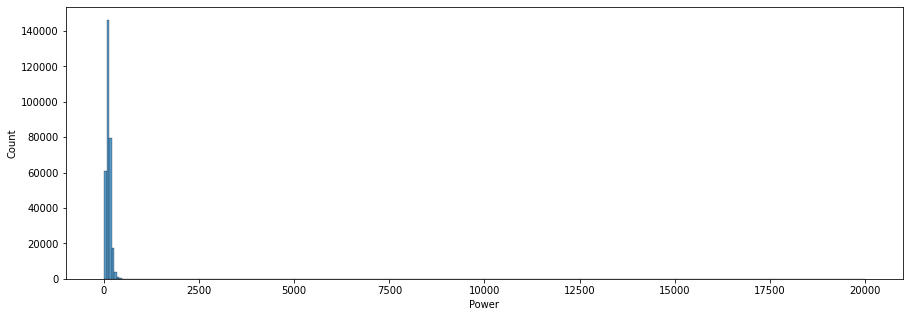

In [27]:
# рассмотрим расспределение по мощности
plt.figure(figsize=(15,5))  
sns.histplot(data['Power'],bins=300)

In [28]:
# Удалим строки с мощностью >1500 и <50
data = data.query('20<Power<1500')

In [29]:
data.groupby('Power').count().sort_values(by='Power')

,Price,VehicleType,RegistrationYear,Gearbox,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
Power,,,,,,,,,,
21,5,5,5,5,5,5,5,5,5,5
22,3,3,3,3,3,3,3,3,3,3
23,33,33,33,33,33,33,33,33,33,33
24,19,19,19,19,19,19,19,19,19,19
25,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...
1405,1,1,1,1,1,1,1,1,1,1
1416,1,1,1,1,1,1,1,1,1,1
1432,1,1,1,1,1,1,1,1,1,1


Рассмотрим столбец **Месяц регистрации**

In [30]:
data.groupby('RegistrationMonth').count().sort_values(by='RegistrationMonth')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
RegistrationMonth,,,,,,,,,,
0,15699,15699,15699,15699,15699,15699,15699,15699,15699,15699
1,19659,19659,19659,19659,19659,19659,19659,19659,19659,19659
2,18405,18405,18405,18405,18405,18405,18405,18405,18405,18405
3,29881,29881,29881,29881,29881,29881,29881,29881,29881,29881
4,25150,25150,25150,25150,25150,25150,25150,25150,25150,25150
5,24944,24944,24944,24944,24944,24944,24944,24944,24944,24944
6,26873,26873,26873,26873,26873,26873,26873,26873,26873,26873
7,23181,23181,23181,23181,23181,23181,23181,23181,23181,23181
8,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295


Большое количество строк с значением ноль, заменим эти строки на медиану.

In [31]:
data.loc[data['RegistrationMonth'] == 0, 'RegistrationMonth'] = data['RegistrationMonth'].median()

In [32]:
data.groupby('RegistrationMonth').count().sort_values(by='RegistrationMonth')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
RegistrationMonth,,,,,,,,,,
1.0,19659,19659,19659,19659,19659,19659,19659,19659,19659,19659
2.0,18405,18405,18405,18405,18405,18405,18405,18405,18405,18405
3.0,29881,29881,29881,29881,29881,29881,29881,29881,29881,29881
4.0,25150,25150,25150,25150,25150,25150,25150,25150,25150,25150
5.0,24944,24944,24944,24944,24944,24944,24944,24944,24944,24944
6.0,42572,42572,42572,42572,42572,42572,42572,42572,42572,42572
7.0,23181,23181,23181,23181,23181,23181,23181,23181,23181,23181
8.0,19295,19295,19295,19295,19295,19295,19295,19295,19295,19295
9.0,20551,20551,20551,20551,20551,20551,20551,20551,20551,20551


Итак, мы заполнили пропущенные значения и обработали аномалии в столбцах, неинформативные признаки были удалены.

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 287536 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              287536 non-null  int64  
 1   VehicleType        287536 non-null  object 
 2   RegistrationYear   287536 non-null  int64  
 3   Gearbox            287536 non-null  object 
 4   Power              287536 non-null  int64  
 5   Model              287536 non-null  object 
 6   Kilometer          287536 non-null  int64  
 7   RegistrationMonth  287536 non-null  float64
 8   FuelType           287536 non-null  object 
 9   Brand              287536 non-null  object 
 10  Repaired           287536 non-null  object 
dtypes: float64(1), int64(4), object(6)
memory usage: 26.3+ MB


In [34]:
data.duplicated().sum()

23116

In [35]:
data = data.drop_duplicates()

In [36]:
data.duplicated().sum()

0

In [37]:
data = data.reset_index(drop=True)

In [38]:
data

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,9800,suv,2004,auto,163,grand,125000,8.0,gasoline,jeep,unknown
1,1500,small,2001,manual,75,golf,150000,6.0,petrol,volkswagen,no
2,3600,small,2008,manual,69,fabia,90000,7.0,gasoline,skoda,no
3,650,sedan,1995,manual,102,3er,150000,10.0,petrol,bmw,yes
4,2200,convertible,2004,manual,109,2_reihe,150000,8.0,petrol,peugeot,no
...,...,...,...,...,...,...,...,...,...,...,...
264415,5250,unknown,2016,auto,150,159,150000,12.0,unknown,alfa_romeo,no
264416,3200,sedan,2004,manual,225,leon,150000,5.0,petrol,seat,yes
264417,1199,convertible,2000,auto,101,fortwo,125000,3.0,petrol,smart,no
264418,9200,bus,1996,manual,102,transporter,150000,3.0,gasoline,volkswagen,no


***Подготовим выборки для обучения моделей***

Так как в нашем распоряжении одна база, то нам необходимо разбить ее на три части: обучающую, валидационную и тестовую. Выделим части в соотношении 60%-20%-20% соответственно

In [39]:
# Выедлим сначала обучающую часть
data_train, data_for_split = train_test_split(data, test_size=0.4, random_state=12345) 
# Далее выделим тестовую и валидационную часть
data_valid, data_test = train_test_split(data_for_split, test_size=0.5, random_state=12345)

In [40]:
#Проверим размеры выборок
len(data_train)

158652

In [41]:
len(data_valid)

52884

In [42]:
len(data_test)

52884

**Создадим переменные для признаков и целевого признака**

In [43]:
features_train = data_train.drop(['Price'], axis=1)
target_train = data_train['Price']
features_valid = data_valid.drop(['Price'], axis=1)
target_valid = data_valid['Price']
features_test = data_test.drop(['Price'], axis=1)
target_test = data_test['Price']

**Далее стандартизируем численные признаки**

In [44]:
# В переменную numeric добавим численные признаки
numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

In [45]:
# для обучающей, валидационной и тестовой выборки
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

**Проведем кодирование категориадьных признаков техникой OHE**

In [46]:
#Выделим категориальные столбцы в переменную
categotical = ['VehicleType', 'Gearbox','Model','FuelType','Brand','Repaired']

features_train_ohe = features_train.copy()

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
# drop='first' удаляет первый признак из закодированных
enc = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
enc.fit(features_train_ohe[categotical])

enc.transform(features_train_ohe[categotical])
#enc.get_feature_names_out() позволяет получить названия колонок
features_train_ohe[enc.get_feature_names_out()] = enc.transform(features_train_ohe[categotical])

# удаляем незакодированные категориальные признаки (изначальные колонки)
features_train_ohe = features_train_ohe.drop(categotical, axis=1)
features_train_ohe

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
222829,0.097987,-0.092187,-0.094565,1.734771,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39826,2.035245,0.206695,0.590735,-0.416953,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
85559,0.694066,-0.918508,-1.053986,-0.724342,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
174046,0.097987,-0.461394,0.590735,-1.031731,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4500,1.886225,-1.076739,-0.094565,-1.339121,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158838,0.545046,-0.883345,-2.150466,-1.031731,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47873,0.545046,1.929661,0.590735,-1.339121,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86398,-0.498093,-1.076739,0.590735,1.119993,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
77285,0.843086,0.857203,0.590735,1.119993,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
features_valid_ohe = features_valid.copy()
features_valid_ohe[enc.get_feature_names_out()] = enc.transform(features_valid_ohe[categotical])
features_valid_ohe = features_valid_ohe.drop(categotical, axis=1)

In [48]:
features_test_ohe = features_test.copy()
features_test_ohe[enc.get_feature_names_out()] = enc.transform(features_test_ohe[categotical])
features_test_ohe = features_test_ohe.drop(categotical, axis=1)

In [49]:
features_test_ohe.head()

,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,...,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,Repaired_unknown,Repaired_yes
234025,-0.349073,-0.092187,0.590735,-1.031731,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
146347,0.694066,0.382508,-0.779866,1.119993,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107137,0.247006,-0.092187,0.590735,-1.339121,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25505,0.396026,-0.092187,0.590735,-1.031731,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173182,0.545046,-0.725114,0.590735,-0.724342,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Обучение моделей

***LinearRegression***

In [ ]:
%%time
#Обучим модель и сделаем предсказания на валидационной выборке 
model1 = LinearRegression()
model1.fit(features_train_ohe,target_train)

In [ ]:
%%time
predictions1_valid = model1.predict(features_valid_ohe)


In [ ]:
rmse_LR = mean_squared_error(target_valid, predictions1_valid, squared= False)
print("RMSE модели:",rmse_LR)

**Проведем кодирование категориадьных признаков техникой OrdinalEncoding**

In [ ]:
features_train_oe = features_train.copy()
features_valid_oe = features_valid.copy()
features_test_oe = features_test.copy()

In [ ]:
features_test_oe

In [ ]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoder.fit(features_train_oe[categotical])

features_train_oe[categotical] = encoder.transform(features_train_oe[categotical])
features_valid_oe[categotical] = encoder.transform(features_valid_oe[categotical])                    
features_test_oe[categotical] = encoder.transform(features_test_oe[categotical])

In [ ]:
features_train_oe

**RandomForestRegressor**

In [57]:
%%time
best_model_forest = None
best_result_forest = 2500
best_est_forest = 0
best_depth_forest = 0
for est in range(80,100,10):
    for depth in range(5,11,5):
        model_forest = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        model_forest.fit(features_train_oe,target_train)
        predictions_valid_forest = model_forest.predict(features_valid_oe) 
        result_forest = mean_squared_error(target_valid, predictions_valid_forest, squared= False)
        print(result_forest)
        if result_forest < best_result_forest:           
            best_model_forest = model_forest
            best_result_forest = result_forest
            best_est_forest = est
            best_depth_forest = depth
print("RMSE модели", best_result_forest, "Количество деревьев:", best_est_forest, "Глубина дерева:",best_depth_forest)

1847.207334207355
RMSE модели 1847.207334207355 Количество деревьев: 90 Глубина дерева: 10
CPU times: user 1min 9s, sys: 484 ms, total: 1min 10s
Wall time: 1min 10s


Обучим модель ***RandomForestRegressor***, которая показала наилучшие результаты

In [58]:
%%time
model_forest_best = RandomForestRegressor(random_state=12345, n_estimators=90, max_depth=10)
model_forest_best.fit(features_train_oe,target_train)

CPU times: user 24 s, sys: 123 ms, total: 24.1 s
Wall time: 24.2 s


RandomForestRegressor(max_depth=10, n_estimators=90, random_state=12345)

In [59]:
%%time
predictions = model_forest_best.predict(features_valid_oe) 

CPU times: user 435 ms, sys: 983 µs, total: 436 ms
Wall time: 446 ms


In [60]:
rmse_forest = mean_squared_error(target_valid,predictions, squared= False)
print(rmse_forest)

1847.207334207355


 **LightGBM**

In [61]:
features_train_gbm = features_train.copy()
features_valid_gbm = features_valid.copy()
features_test_gbm = features_test.copy()

In [62]:
features_train_gbm[categotical] = features_train_gbm[categotical].astype('category')
features_valid_gbm[categotical] = features_valid_gbm[categotical].astype('category')
features_test_gbm[categotical] = features_test_gbm[categotical].astype('category')

In [63]:
features_train_gbm

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
222829,sedan,0.097987,manual,-0.092187,3er,-0.094565,1.734771,petrol,bmw,no
39826,unknown,2.035245,manual,0.206695,a3,0.590735,-0.416953,unknown,audi,unknown
85559,small,0.694066,manual,-0.918508,yaris,-1.053986,-0.724342,petrol,toyota,no
174046,convertible,0.097987,manual,-0.461394,other,0.590735,-1.031731,petrol,ford,no
4500,unknown,1.886225,manual,-1.076739,punto,-0.094565,-1.339121,petrol,fiat,no
...,...,...,...,...,...,...,...,...,...,...
158838,small,0.545046,auto,-0.883345,fortwo,-2.150466,-1.031731,petrol,smart,no
47873,wagon,0.545046,auto,1.929661,3er,0.590735,-1.339121,gasoline,bmw,no
86398,small,-0.498093,manual,-1.076739,polo,0.590735,1.119993,petrol,volkswagen,no
77285,suv,0.843086,auto,0.857203,q5,0.590735,1.119993,gasoline,audi,no


In [64]:
features_train_gbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158652 entries, 222829 to 217570
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        158652 non-null  category
 1   RegistrationYear   158652 non-null  float64 
 2   Gearbox            158652 non-null  category
 3   Power              158652 non-null  float64 
 4   Model              158652 non-null  category
 5   Kilometer          158652 non-null  float64 
 6   RegistrationMonth  158652 non-null  float64 
 7   FuelType           158652 non-null  category
 8   Brand              158652 non-null  category
 9   Repaired           158652 non-null  category
dtypes: category(6), float64(4)
memory usage: 7.1 MB


In [65]:
%%time

model_lgbmr = LGBMRegressor(learning_rate=0.3, num_leaves=20, random_state=12345, categorical_feature=categotical)
model_lgbmr.fit(features_train_gbm, target_train)

CPU times: user 2min 49s, sys: 2 s, total: 2min 51s
Wall time: 2min 52s


LGBMRegressor(categorical_feature=['VehicleType', 'Gearbox', 'Model',
                                   'FuelType', 'Brand', 'Repaired'],
              learning_rate=0.3, num_leaves=20, random_state=12345)

In [66]:
%%time

predictions_lgbmr = model_lgbmr.predict(features_valid_gbm)


CPU times: user 411 ms, sys: 0 ns, total: 411 ms
Wall time: 401 ms


In [67]:
rmse_lgbmr = mean_squared_error(target_valid, predictions_lgbmr,squared= False)
print('RMSE:', rmse_lgbmr)

RMSE: 1594.373753291449


**Поменяем гипперпараметры модели LightGBM**, установим learning_rate=0.1, num_leaves=30 и посмотрим как изменится качество

In [ ]:
%%time

model_lgbmr1 = LGBMRegressor(learning_rate=0.1, num_leaves=30, random_state=12345, categorical_feature=categotical)
model_lgbmr1.fit(features_train_gbm, target_train)

In [ ]:
%%time

predictions_lgbmr1 = model_lgbmr1.predict(features_valid_gbm)


In [ ]:
rmse_lgbmr1 = mean_squared_error(target_valid, predictions_lgbmr1,squared= False)
print('RMSE:', rmse_lgbmr1)

**CatBoostRegressor**

In [ ]:
%%time
model_cbr = CatBoostRegressor(learning_rate=0.1, random_state=12345, cat_features = categotical, verbose=False) 
model_cbr.fit(features_train_gbm, target_train)

In [ ]:
%%time
model_cbr_oe = CatBoostRegressor(learning_rate=0.1, random_state=12345, verbose=False) 
model_cbr_oe.fit(features_train_oe, target_train)

In [ ]:
%%time

predictions_cbr = model_cbr.predict(features_valid_gbm)


In [ ]:
rmse_cbr = mean_squared_error(target_valid, predictions_cbr, squared=False)
print('RMSE:', rmse_cbr)

In [ ]:
%%time

predictions_cbr_oe = model_cbr_oe.predict(features_valid_oe)


In [ ]:
rmse_cbr_oe = mean_squared_error(target_valid, predictions_cbr_oe, squared=False)
print('RMSE:', rmse_cbr_oe)

## Анализ моделей

Таким образом, лучшую метрику качества показала модель CatBoostRegressor, также она оптимальна по времени обучения и скорости предсказания.

Проверим качество модели на тестовых данных.

In [ ]:
%%time

predictions_cbr_test = model_cbr.predict(features_test_gbm)

In [ ]:
rmse_cbr_test = mean_squared_error(target_test, predictions_cbr_test, squared=False)
print('RMSE:', rmse_cbr_test)

Значение RMSE на тестовых данных не сильно изменилось, качество модели удовлетворяет нашим требованиям.

**Общий вывод**

Необходимо было построить модель для определения стоимости автомобиля, с лушими показателями качества предсказания, скорости и врмени обучения. 
Мы использовали для обучения модели CatBoostRegressor, LightGBM, LinearRegression, RandomForestRegressor.

По итогам качества и скорости обучения побеждает модель ***CatBoostRegressor***, рекомендуем данную модель для определения рыночной стоимости авотмобиля.
